In [1]:
# import

import pickle
import numpy as np
import csv
import cv2

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers.core import Dense, Dropout,Lambda
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam

%matplotlib inline

Using TensorFlow backend.


In [2]:
# read in training log 
data_folder = './data/data/'

log_path = data_folder + 'driving_log.csv'
logs = []
with open(log_path,'r') as f:
    reader = csv.reader(f)
    for line in reader:
        logs.append(line)
    # remove the first row in the logs
    # https://stackoverflow.com/questions/4426663/how-do-i-remove-the-first-item-from-a-python-list
    logs.pop(0)

#print(logs)
print(len(logs))

8036


In [3]:
# preprocess the image data by resizing 
# preprocess the image data by changing the image color space from RGB to HSV and keep S channel only
def image_preprocessing(img):
    resized = cv2.resize((cv2.cvtColor(img, cv2.COLOR_RGB2HSV))[:,:,1],(img_cols,img_rows))
    return resized

# resize the images to 16X32
img_rows = 16
img_cols = 32

# batch size and epochs
batch_size = 128
EPOCHS= 10

In [4]:
# Read in center imags 
# preprocess center images
X = []
y = []

for i in range(len(logs)):
    img_path = logs[i][0]
    img_path = data_folder+'IMG'+(img_path.split('IMG')[1])
    #print(img_path)
    img = plt.imread(img_path)
    X.append(image_preprocessing(img))
    y.append(float(logs[i][3]))
print(len(y))

8036


In [5]:
# Read in left imags 
# preprocess left images
# add 0.3 adjusted steering measurements for the left camera images
for i in range(len(logs)):
    img_path = logs[i][1]
    img_path = data_folder+'IMG'+(img_path.split('IMG')[1])
    img = plt.imread(img_path)
    X.append(image_preprocessing(img))
    y.append(float(logs[i][3]) + 0.25)
print(len(y))

16072


In [6]:
# Read in right image 
# preprocess right images
# substract 0.3 adjusted steering measurements for the right camera images
for i in range(len(logs)):
    img_path = logs[i][2]
    img_path = data_folder+'IMG'+(img_path.split('IMG')[1])
    img = plt.imread(img_path)
    X.append(image_preprocessing(img))
    y.append(float(logs[i][3]) - 0.25)
print(len(y))

24108


Training image example number: 1755


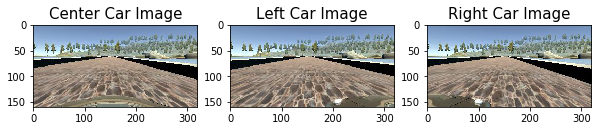

In [7]:
# read in a list of random example images
img_ind = np.random.randint(0, len(logs))
# read in random center image
img_path_center = logs[img_ind][0]
img_path_center = data_folder+'IMG'+(img_path_center.split('IMG')[1])
img_center = plt.imread(img_path_center)
# read in random left image
img_path_left = logs[img_ind][1]
img_path_left = data_folder+'IMG'+(img_path_left.split('IMG')[1])
img_left = plt.imread(img_path_left)
# read in random right image
img_path_right = logs[img_ind][2]
img_path_right = data_folder+'IMG'+(img_path_right.split('IMG')[1])
img_right = plt.imread(img_path_right)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
ax1.imshow(img_center)
ax1.set_title('Center Car Image', fontsize=15)
ax2.imshow(img_left)
ax2.set_title('Left Car Image', fontsize=15)
ax3.imshow(img_right)
ax3.set_title('Right Car Image', fontsize=15)

print('Training image example number:', img_ind)

In [8]:
data={}
data['features'] = X
data['labels'] = y

X_train, y_train = data['features'], data['labels']

In [9]:
X_train = np.array(data['features']).astype('float32')
y_train = np.array(data['labels']).astype('float32')

In [10]:
# generate more data by reflection  
X_train = np.append(X_train,X_train[:,:,::-1],axis=0)
y_train = np.append(y_train,-y_train,axis=0)

In [11]:
# shuffle data and then split data into training and validation 
X_train, y_train = shuffle(X_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=0, test_size=0.1)

In [12]:
# reshape the training and validation data to (None, 16, 32, 1)
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, 1)

print("Training Image Shape:     {}".format(X_train[0].shape))
print("Training Set:    {} samples".format(len(X_train)))
print()
print("Validation Image Shape:     {}".format(X_valid[0].shape))
print("Validation Set:    {} samples".format(len(X_valid)))

Training Image Shape:     (16, 32, 1)
Training Set:    43394 samples

Validation Image Shape:     (16, 32, 1)
Validation Set:    4822 samples


In [13]:
# define the model
# one conv and one fully connected layer 
model = Sequential([Lambda(lambda x: x/127.5 - 1.,input_shape=(img_rows,img_cols,1)),
                    Conv2D(2, (3, 3), input_shape=(img_rows,img_cols,1), activation='relu', padding = 'valid'),
                    MaxPooling2D((4,4),(4,4),'valid'),
                    Dropout(0.25),
                    Flatten(),
                    Dense(1)])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 16, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 30, 2)         20        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 7, 2)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 7, 2)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 42)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 43        
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________


In [14]:
# train the model
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train, y_train, batch_size=batch_size, epochs=EPOCHS,verbose=1, validation_data=(X_valid, y_valid))

Train on 43394 samples, validate on 4822 samples
Epoch 1/10
43394/43394 [==============================] - 5s 122us/step - loss: 0.1184 - val_loss: 0.0493
Epoch 2/10
43394/43394 [==============================] - 4s 96us/step - loss: 0.0479 - val_loss: 0.0374
Epoch 3/10
43394/43394 [==============================] - 4s 95us/step - loss: 0.0391 - val_loss: 0.0328
Epoch 4/10
43394/43394 [==============================] - 5s 107us/step - loss: 0.0360 - val_loss: 0.0310
Epoch 5/10
43394/43394 [==============================] - 4s 99us/step - loss: 0.0345 - val_loss: 0.0306
Epoch 6/10
43394/43394 [==============================] - 4s 97us/step - loss: 0.0340 - val_loss: 0.0300
Epoch 7/10
43394/43394 [==============================] - 5s 104us/step - loss: 0.0335 - val_loss: 0.0292
Epoch 8/10
43394/43394 [==============================] - 4s 103us/step - loss: 0.0331 - val_loss: 0.0293
Epoch 9/10
43394/43394 [==============================] - 4s 101us/step - loss: 0.0326 - val_loss: 0.0291
E

In [15]:
# save the model
model.save('model_small.h5')  
print("Model saved.")

Model saved.
